<a href="https://colab.research.google.com/github/LuisJavierFI/Computer-Vision---D.Operaciones/blob/main/4_Departamento_de_Operaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos
* Crear un clasificador de imágenes: Sano, Covid-19, Pneumonía Bacterial y Pneumonía Vírica
* Deep Learning, redes neuronales residuales
* Transger learning

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
XRay_Directory = "/content/drive/MyDrive/FROGAMES/ML/Proyecto!!!/CV-images/Dataset"

In [4]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['2', '1', '3', '0']

In [5]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)


In [6]:
# Generar lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")

Found 428 images belonging to 4 classes.


In [7]:
# validacion
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 104 images belonging to 4 classes.


In [8]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [12]:
# Traductor de cada Etiqueta
label_names = {0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia Virica', 3: 'Pneumonia Bacteriana'}

# Visualización del dataset

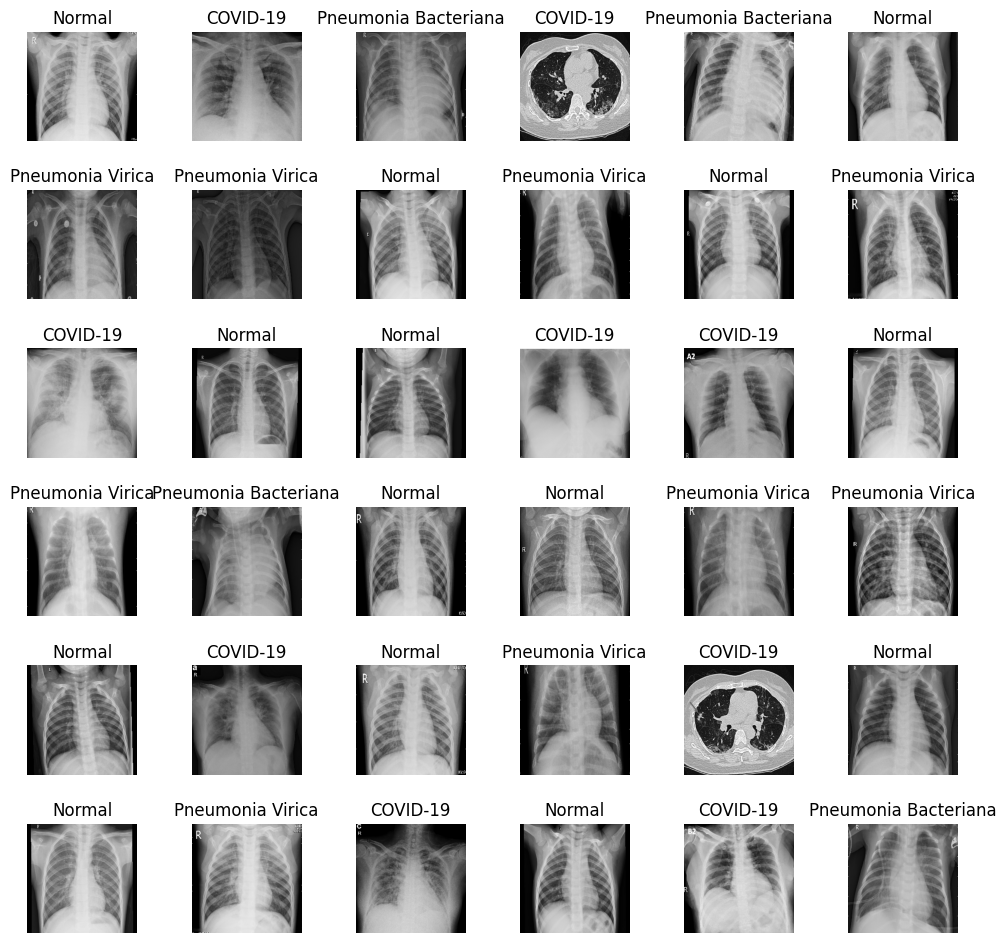

In [13]:
# Crear una matriz de 36 imágenes junto con sus etiquetas correspondientes

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# Importar el modelo con pesos pre-entrenados
## Transfer learning

In [14]:
basemodel = ResNet50(weights = "imagenet",
                     include_top = False, # no incluir la capa de entrada, esa será nuestra red
                     input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [16]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5
for layer in basemodel.layers[:-10]:
    layer.trainable = False #congelar capas

# Mi Red Neuronal

In [17]:
headmodel = basemodel.output #la salida de ResNet50 es el inicio de nuestra red
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.legacy.RMSprop(lr = 1e-4, decay = 1e-6), metrics = ["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25,
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

<ipython-input-21-72089ba24042>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25,


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.3633 - accuracy: 0.3692
Epoch 1: val_loss improved from inf to 1.29285, saving model to weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 119s 1s/step - loss: 1.3633 - accuracy: 0.3692 - val_loss: 1.2928 - val_accuracy: 0.3077
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.0761 - accuracy: 0.5140
Epoch 2: val_loss improved from 1.29285 to 1.24696, saving model to weights.hdf5
107/107 [==============================] - 11s 100ms/step - loss: 1.0761 - accuracy: 0.5140 - val_loss: 1.2470 - val_accuracy: 0.3846
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.6121
Epoch 3: val_loss did not improve from 1.24696
107/107 [==============================] - 10s 96ms/step - loss: 0.9380 - accuracy: 0.6121 - val_loss: 1.8104 - val_accuracy: 0.3750
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.6028
Epoch 4: val_loss improved from 1.24696 to 0.89751, saving model to weights.hdf5
107/107 [==============================] - 10s 89ms/step - loss: 0.8832 - accuracy: 0.6028 - val_loss: 0

# Evaluar el modelo

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

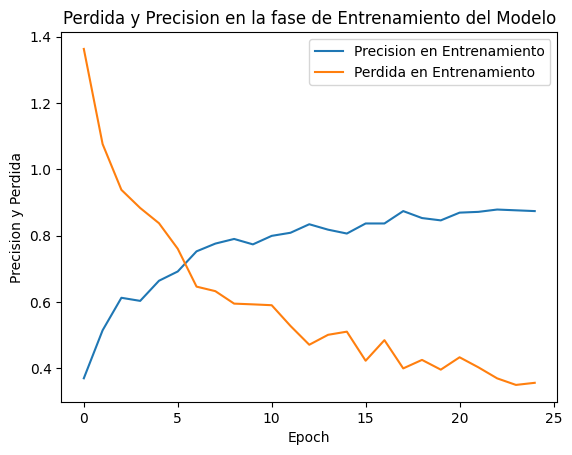

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

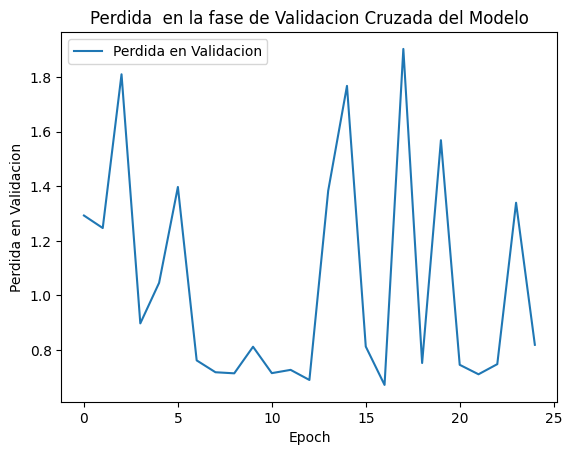

In [24]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

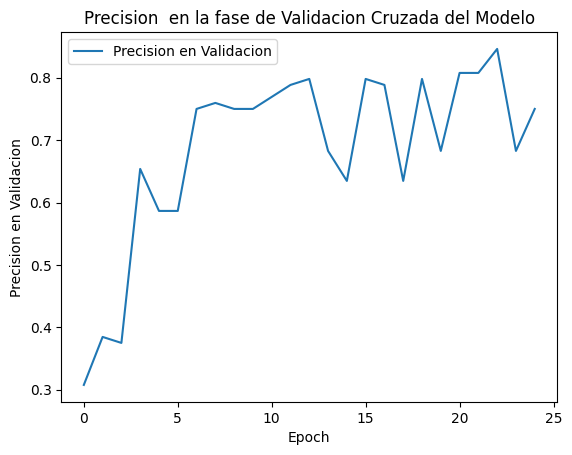

In [25]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [26]:
test_directory = "/content/drive/MyDrive/FROGAMES/ML/Proyecto!!!/CV-images/Test"

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-27-9da2758a8081>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)


 1/10 [==>...........................] - ETA: 33s - loss: 1.2203 - accuracy: 0.5500

10/10 [==============================] - 4s 10ms/step - loss: 1.2203 - accuracy: 0.5500
Precision en la fase de Test : 0.550000011920929


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 22ms/step


In [29]:
len(original)

40

In [30]:
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

Eficacia de la prediccion 0.55


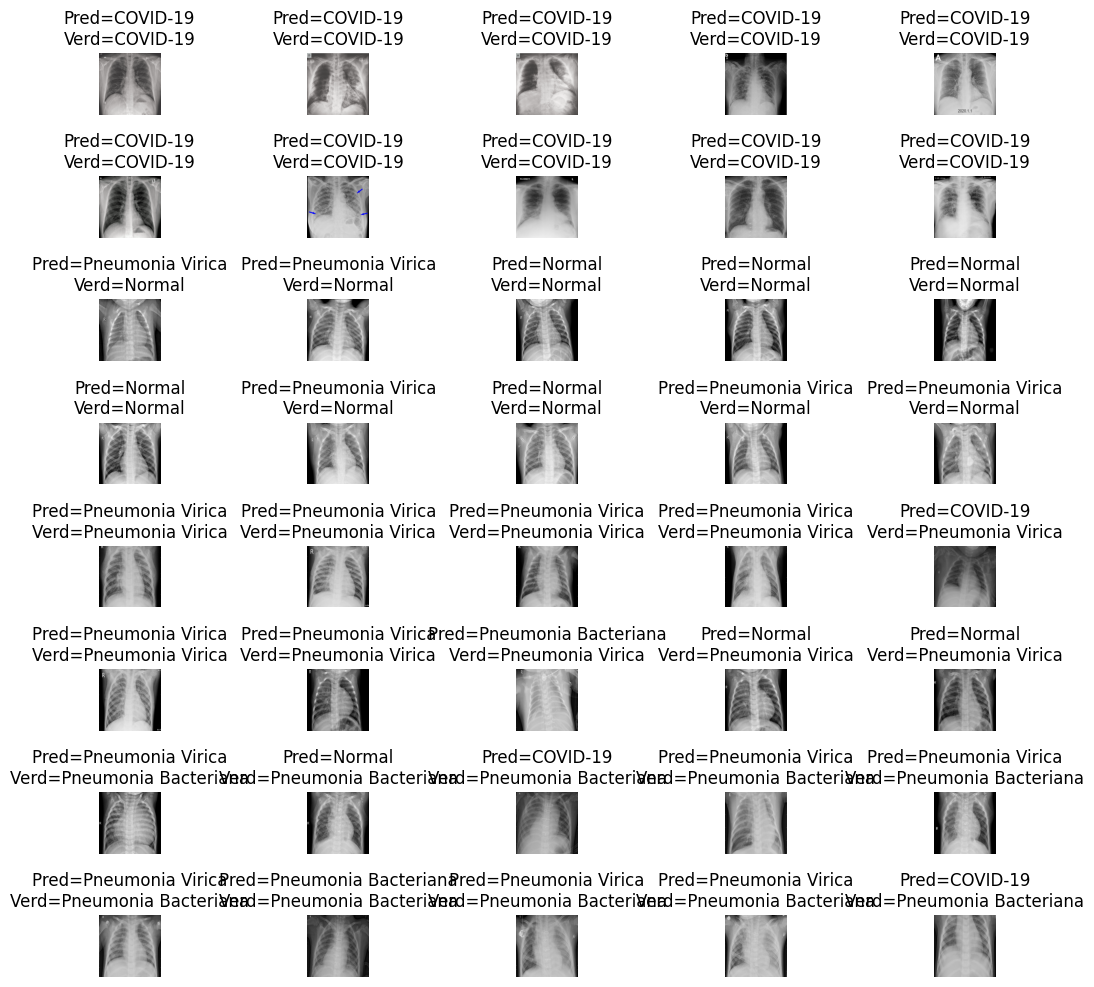

In [31]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [32]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.62      0.50      0.56        10
           2       0.35      0.60      0.44        10
           3       0.50      0.10      0.17        10

    accuracy                           0.55        40
   macro avg       0.56      0.55      0.51        40
weighted avg       0.56      0.55      0.51        40



Text(0.5, 1.0, 'Matriz de Confusion')

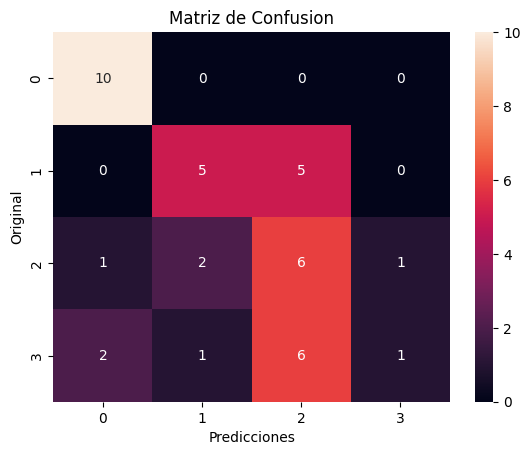

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")